In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import mlp
import importlib
from sklearn.model_selection import train_test_split
import sklearn
from matplotlib import pyplot as plt
from os.path import join

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
dir = 'preprocessed'
setting_1 = dict(
    x_train = np.loadtxt(join(dir, 'x_train.csv'), delimiter=','),
    y_train = np.expand_dims(np.loadtxt(join(dir, 'y_train.csv'), delimiter=','), axis=1),
    x_valid = np.loadtxt(join(dir, 'x_valid.csv'), delimiter=','),
    y_valid = np.expand_dims(np.loadtxt(join(dir, 'y_valid.csv'), delimiter=','), axis=1),
    x_test = np.loadtxt(join(dir, 'x_test.csv'), delimiter=','),
    y_test = np.expand_dims(np.loadtxt(join(dir, 'y_test.csv'), delimiter=','), axis=1),
)

setting_2 = dict(
    x_train = np.loadtxt(join(dir, 'x_train_resampled.csv'), delimiter=','),
    y_train = np.expand_dims(np.loadtxt(join(dir, 'y_train_resampled.csv'), delimiter=','), axis=1),
    x_valid = np.loadtxt(join(dir, 'x_valid.csv'), delimiter=','),
    y_valid = np.expand_dims(np.loadtxt(join(dir, 'y_valid.csv'), delimiter=','), axis=1),
    x_test = np.loadtxt(join(dir, 'x_test.csv'), delimiter=','),
    y_test = np.expand_dims(np.loadtxt(join(dir, 'y_test.csv'), delimiter=','), axis=1),
)

In [19]:
for data in setting_1:
    setting_1[data] = torch.from_numpy(setting_1[data]).float().to(device)

for data in setting_2:
    setting_2[data] = torch.from_numpy(setting_2[data]).float().to(device)

In [20]:
size_feature = setting_1['x_train'].shape[1]
size_train = setting_1['x_train'].shape[0]
size_test = setting_1['x_test'].shape[0]
print(f'feature size: {size_feature} | train size: {size_train} | test size: {size_test}')

feature size: 44 | train size: 76538 | test size: 9568


In [81]:
def train(model, x_train, y_train, x_valid, y_valid, config):
    loader_train = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=config['batch_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['decay'])
    criterion = torch.nn.BCEWithLogitsLoss()

    loss_record_train = []
    loss_record_valid = []

    for epoch in range(config['num_epoch']):
        model.train()
        for i, (x, y) in enumerate(loader_train):
            out = model(x)
            loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        out_train = model(x_train)
        loss_train = criterion(out_train, y_train).detach().item()
        loss_record_train.append(loss_train)
        yhat_train = torch.round(torch.sigmoid(out_train)).detach()
        acurracy_train = sklearn.metrics.accuracy_score(y_train.cpu().numpy(), yhat_train.cpu().numpy())

        out_valid = model(x_valid)
        loss_valid = criterion(out_valid, y_valid).detach().item()
        loss_record_valid.append(loss_valid)
        yhat_valid = torch.round(torch.sigmoid(out_valid)).detach()
        acurracy_valid = sklearn.metrics.accuracy_score(y_valid.cpu().numpy(), yhat_valid.cpu().numpy())

        print(f'\r[Info] epoch: {epoch + 1}/{config["num_epoch"]} | training loss: {loss_train} | training accuracy: {acurracy_train} | validation loss: {loss_valid} | validation accuracy: {acurracy_valid}', end='')
    print('\n[Info] Done')
    return loss_record_train, loss_record_valid

def cross_validation(x_train, y_train, x_valid, y_valid, config):
    model = mlp.MLP(config['size_feature'], 1, config['hidden_layers'], config['act'], with_bn=config['with_bn'], with_do=config['with_do']).to(device)
    loss_record_train, loss_record_valid = train(model, x_train, y_train, x_valid, y_valid, config)
    plt.plot(loss_record_train, label='training')
    plt.plot(loss_record_valid, label='validation')
    plt.legend()
    plt.show()
    return loss_record_valid

## Explore different hidden layers configuration

### Impact of hidden unit size

In [83]:
config = dict(
    size_feature = size_feature,
    act = 'tanh',
    with_do = False,
    with_bn = False,
    batch_size = 512,
    num_epoch = 10,
    lr = 1e-3,
    decay = 1e-6,
)

[Info] epoch: 10/10 | training loss: 0.43416091799736023 | training accuracy: 0.8788836917609554 | validation loss: 0.433913916349411 | validation accuracy: 0.8794815511654647
[Info] Done


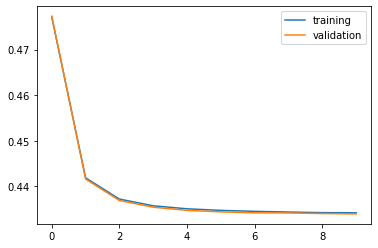

In [86]:
config['hidden_layers'] = [32]
loss_record_valid_32 = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.4286668598651886 | training accuracy: 0.8843189004154799 | validation loss: 0.42677080631256104 | validation accuracy: 0.886275739521271
[Info] Done


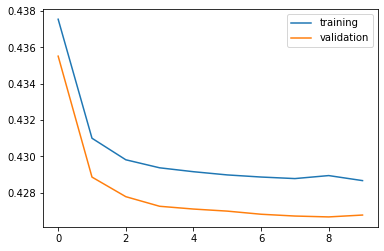

In [87]:
config['hidden_layers'] = [128]
loss_record_valid_128 = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.42734357714653015 | training accuracy: 0.8857168987953696 | validation loss: 0.42594531178474426 | validation accuracy: 0.8873209992683182
[Info] Done


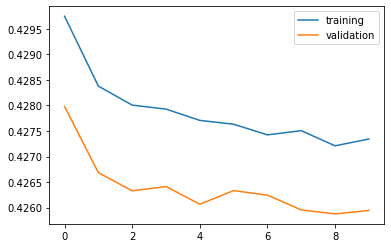

In [88]:
config['hidden_layers'] = [512]
loss_record_valid_512 = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

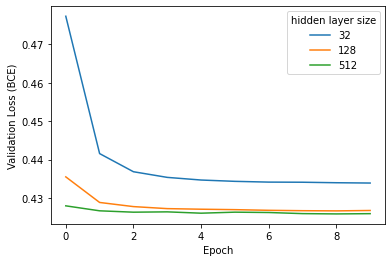

In [91]:
plt.plot(loss_record_valid_32, label='32')
plt.plot(loss_record_valid_128, label='128')
plt.plot(loss_record_valid_512, label='512')
plt.legend(title='hidden layer size')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (BCE)')
plt.show()

As the size of the hidden unit increases, the model overfits more, which makes sense. However, the training and validation accuracies both increase. There is a tradeoff between overfitting and accuracy.

### Impact of the number of hidden layers

[Info] epoch: 10/10 | training loss: 0.4287211000919342 | training accuracy: 0.884541012307612 | validation loss: 0.426150381565094 | validation accuracy: 0.8871119473189087
[Info] Done


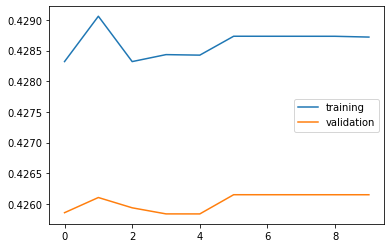

In [92]:
config['hidden_layers'] = [512] * 2
loss_record_valid_2 = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.4290342628955841 | training accuracy: 0.8842274425775432 | validation loss: 0.4262542426586151 | validation accuracy: 0.8870074213442041
[Info] Done


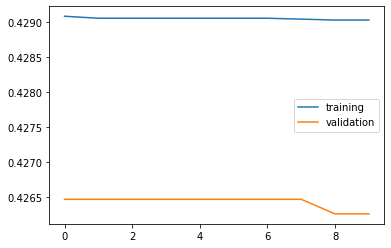

In [93]:
config['hidden_layers'] = [512] * 4
loss_record_valid_4 = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.5785807967185974 | training accuracy: 0.7346808121456009 | validation loss: 0.5746811032295227 | validation accuracy: 0.73858053726351
[Info] Done


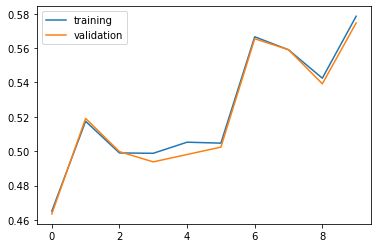

In [94]:
config['hidden_layers'] = [512] * 8
loss_record_valid_8 = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

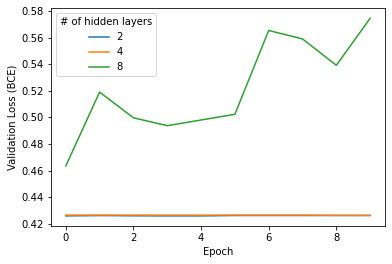

In [95]:
plt.plot(loss_record_valid_2, label='2')
plt.plot(loss_record_valid_4, label='4')
plt.plot(loss_record_valid_8, label='8')
plt.legend(title='# of hidden layers')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (BCE)')
plt.show()

Having more layers helps the model to converge better but also increases the chance of overfitting. There is a tradeoff we need to make.

### Impact of the activation function (ReLU vs. Tanh)

[Info] epoch: 10/10 | training loss: 0.43028855323791504 | training accuracy: 0.8829731636572683 | validation loss: 0.4274040162563324 | validation accuracy: 0.8858576356224522
[Info] Done


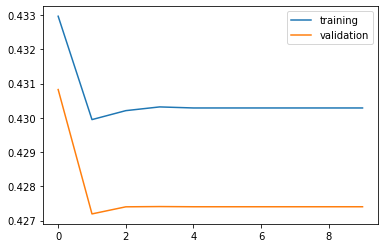

In [96]:
config['hidden_layers'] = [512] * 4
config['act'] = 'tanh'
loss_record_valid_tanh = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.6931475400924683 | training accuracy: 0.8848676474431002 | validation loss: 0.6931472420692444 | validation accuracy: 0.8876345771924323
[Info] Done


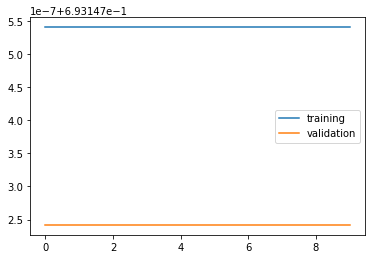

In [97]:
config['act'] = 'relu'
loss_record_valid_relu = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

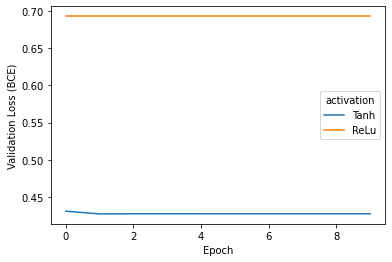

In [98]:
plt.plot(loss_record_valid_tanh, label='Tanh')
plt.plot(loss_record_valid_relu, label='ReLu')
plt.legend(title='activation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (BCE)')
plt.show()

Tanh performs better in the above experiment. We will use Tanh from now on.

## Impact of Dropout layer

[Info] epoch: 10/10 | training loss: 0.4285508692264557 | training accuracy: 0.8847108625780657 | validation loss: 0.42604517936706543 | validation accuracy: 0.8872164732936134
[Info] Done


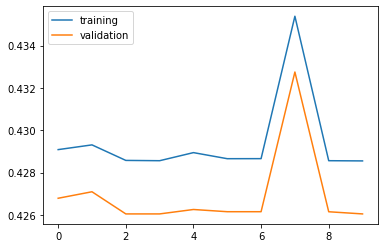

In [100]:
config['act'] = 'tanh'
config['with_do'] = True
loss_record_valid_do = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

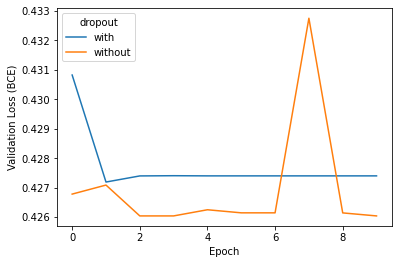

In [101]:
plt.plot(loss_record_valid_tanh, label='with')
plt.plot(loss_record_valid_do, label='without')
plt.legend(title='dropout')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (BCE)')
plt.show()

As expected, dropout layer significantly reduces overfitting. I am going to keep it.

## Impact of BatchNorm

[Info] epoch: 10/10 | training loss: 0.4722851514816284 | training accuracy: 0.8848676474431002 | validation loss: 0.4715160131454468 | validation accuracy: 0.8876345771924323
[Info] Done


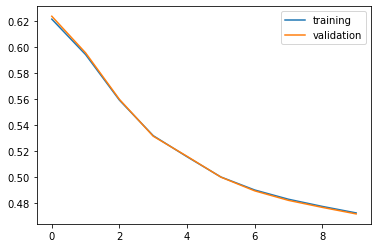

In [102]:
config['with_bn'] = True
loss_record_valid_bn = cross_validation(setting_1['x_train'], setting_1['y_train'], setting_1['x_valid'], setting_1['y_valid'], config)

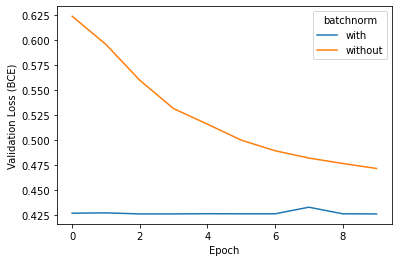

In [103]:
plt.plot(loss_record_valid_do, label='with')
plt.plot(loss_record_valid_bn, label='without')
plt.legend(title='batchnorm')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (BCE)')
plt.show()

## Evaluate the best model on test data

In [110]:
best_config = dict(
    size_feature = size_feature,
    act = 'tanh',
    hidden_layers = [512] * 4,
    with_do = True,
    with_bn = True,
    batch_size = 512,
    num_epoch = 25,
    lr = 5e-4,
    decay = 1e-6,
)

[Info] epoch: 25/25 | training loss: 0.42889055609703064 | training accuracy: 0.884371162037158 | validation loss: 0.43261826038360596 | validation accuracy: 0.8806438127090301
[Info] Done


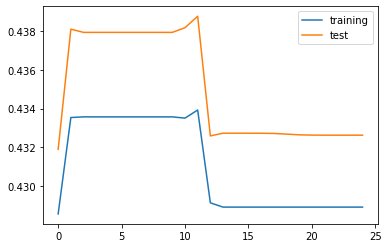

In [124]:
best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
loss_record_train, loss_record_valid = train(best_model, setting_1['x_train'], setting_1['y_train'], setting_1['x_test'], setting_1['y_test'], best_config)
plt.plot(loss_record_train, label='training')
plt.plot(loss_record_valid, label='test')
plt.legend()
plt.show()

In [125]:
best_model.eval()
yhat_test = torch.round(torch.sigmoid(best_model(setting_1['x_test'])))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = setting_1['y_test'].cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      8432
         1.0       0.20      0.00      0.00      1136

    accuracy                           0.88      9568
   macro avg       0.54      0.50      0.47      9568
weighted avg       0.80      0.88      0.83      9568



In [113]:
print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

roc auc score: 0.5008460392335035


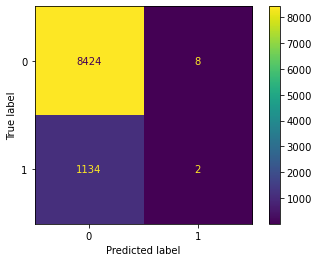

In [126]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.savefig('cm_setting_1.png')
plt.show()

[Info] epoch: 25/25 | training loss: 0.6483400464057922 | training accuracy: 0.6288016341352701 | validation loss: 0.6638264656066895 | validation accuracy: 0.6070234113712375
[Info] Done


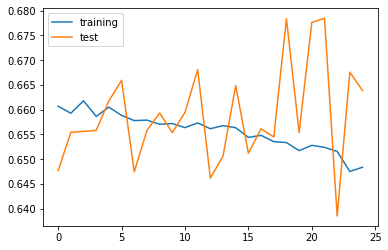

In [115]:
best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
loss_record_train, loss_record_valid = train(best_model, setting_2['x_train'], setting_2['y_train'], setting_2['x_test'], setting_2['y_test'], best_config)
plt.plot(loss_record_train, label='training')
plt.plot(loss_record_valid, label='test')
plt.legend()
plt.show()

In [116]:
best_model.eval()
yhat_test = torch.round(torch.sigmoid(best_model(setting_1['x_test'])))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = setting_1['y_test'].cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.92      0.61      0.73      8432
         1.0       0.17      0.59      0.26      1136

    accuracy                           0.61      9568
   macro avg       0.54      0.60      0.50      9568
weighted avg       0.83      0.61      0.68      9568



In [117]:
print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

roc auc score: 0.5988053558542908


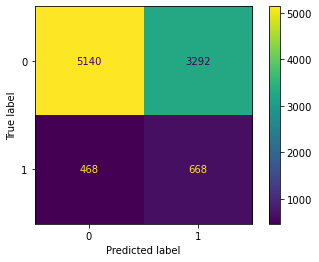

In [121]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.savefig('cm_setting_2.png')
plt.show()

In [79]:
for i in range(5):
    best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
    train(best_model, setting_1['x_train'], setting_1['y_train'], setting_1['x_test'], setting_1['y_test'], best_config)

    best_model.eval()
    yhat_test = torch.round(torch.sigmoid(best_model(setting_1['x_test'])))
    yhat_test_ = yhat_test.detach().cpu().numpy()
    y_test_ = setting_1['y_test'].cpu().numpy()
    print(sklearn.metrics.classification_report(y_test_, yhat_test_))
    print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

[Info] epoch: 20/20 | training loss: 0.4275355935096741 | training accuracy: 0.8855731793357547 | validation loss: 0.43185117840766907 | validation accuracy: 0.881061872909699
[Info] Done
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      8432
         1.0       0.43      0.01      0.01      1136

    accuracy                           0.88      9568
   macro avg       0.66      0.50      0.47      9568
weighted avg       0.83      0.88      0.83      9568

roc auc score: 0.5021664617687147
[Info] epoch: 20/20 | training loss: 0.4274539351463318 | training accuracy: 0.8855470485249157 | validation loss: 0.43213269114494324 | validation accuracy: 0.881061872909699
[Info] Done
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      8432
         1.0       0.47      0.02      0.03      1136

    accuracy                           0.88      9568
   macro avg       0.68      0.51      0.48  

In [80]:
for i in range(5):
    best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
    train(best_model, setting_2['x_train'], setting_2['y_train'], setting_2['x_test'], setting_2['y_test'], best_config)

    best_model.eval()
    yhat_test = torch.round(torch.sigmoid(best_model(setting_2['x_test'])))
    yhat_test_ = yhat_test.detach().cpu().numpy()
    y_test_ = setting_2['y_test'].cpu().numpy()
    print(sklearn.metrics.classification_report(y_test_, yhat_test_))
    print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

[Info] epoch: 20/20 | training loss: 0.6556773781776428 | training accuracy: 0.6122900590104403 | validation loss: 0.6390630006790161 | validation accuracy: 0.6706730769230769
[Info] Done
              precision    recall  f1-score   support

         0.0       0.92      0.69      0.79      8432
         1.0       0.19      0.53      0.28      1136

    accuracy                           0.67      9568
   macro avg       0.55      0.61      0.53      9568
weighted avg       0.83      0.67      0.73      9568

roc auc score: 0.609020465296523
[Info] epoch: 20/20 | training loss: 0.6553608179092407 | training accuracy: 0.6113254652746255 | validation loss: 0.6454089283943176 | validation accuracy: 0.6612667224080268
[Info] Done
              precision    recall  f1-score   support

         0.0       0.92      0.68      0.78      8432
         1.0       0.18      0.54      0.28      1136

    accuracy                           0.66      9568
   macro avg       0.55      0.61      0.53   